### Данные - Ирисы Фишера

Выборка формируется из 3 и 4 столбца признаков, а именно petalLength и 
petalWidht.

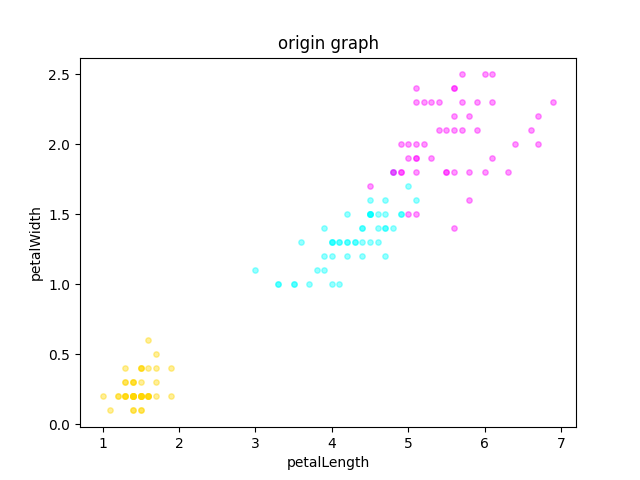


### Описание алгоритма

Основная идея алгоритма заключается в том, чтобы считать веса не как функцию от порядка соседа, а как функцию от расстояния до него. Введем функцию ядра:
$K(z)$ невозрастающую на $[0; + \infty )$. Задав теперь веса в виде:

$w(i, u) = K(\frac{ρ(y, x_{u}^{(i)})}{h})$, 

где, параметр h называется шириной окна. Классификатор, описанный для k взвешенных ближайших соседей примет вид:

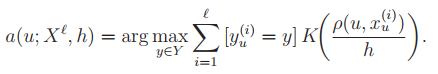

Ширина окна находится из метода (k заменяется на h) Leave-one-out.

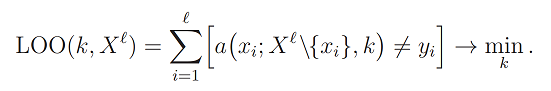

Для рассчетов осталось определить функцию ядра, то есть окна. Их будет рассмотрено 2 вида:



*   K(z) = $(h - |z|)_+$
*   K(z) = $\frac{1}{2} · [h - |z|]$



Шарина окна может быть переменной, тогда выражение примет вид:

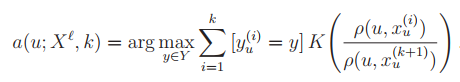

Но в текущем решении, этот случай не рассматривается.

Если ширина окна является переменной, тогда она зависит от рассматриваемого объекта. Неформально, в методе парзеновского окна, объекты попавшие в окно рассматриваемого объекта голосуют за причисления его к своему классу. 

В дальнейшем ширина окна h, будет обозначенна как p.

### Код программы

Методы с парзеновским окном наследуются от абстрактного метода ближайших соседей:

In [ ]:
from abc import ABC, abstractmethod
import pandas as pd


class AbstractKNeighborsMethod(ABC):
    _k: int
    _objects: list
    _answers: list
    answer_set: list
    _objects_neighbors: list

    gamma_data: dict
    current_neighbors: list

    def __init__(self, objects: pd.DataFrame, answers: pd.DataFrame, k, is_column_name=True):
        if is_column_name:
            objects.columns = objects.iloc[0]
            answers.columns = answers.iloc[0]
        self.objects = objects
        self.answers = answers
        self.k = k
        self.set_neighbors_for_objects()

    @property
    def k(self):
        return self._k

    @k.setter
    def k(self, val):
        if val <= 0:
            print("k must be > 0")
        self._k = val

    @property
    def objects(self):
        return self._objects

    @objects.setter
    def objects(self, val):
        self._objects = []
        for index, obj in val.iterrows():
            self._objects.append((index, tuple(obj.tolist())))

    @property
    def answers(self):
        return self._answers

    @answers.setter
    def answers(self, val):
        self._answers = []
        for _, answer in val.iterrows():
            self._answers.append(answer.tolist()[0])
        # Формирование упорядоченого множества
        self.answer_set = list(dict.fromkeys(self._answers))

    def set_neighbors_for_objects(self):
        self._objects_neighbors = []
        for obj in self.objects:
            self._objects_neighbors.append(self.neighbors(obj))

    def add_object_answer(self, new_object, new_answer, is_without_index=True):
        if is_without_index:
            new_object = (len(self.objects), new_object)
        self.objects.append(new_object)
        self.answers.append(new_answer)
        if not self.answers.__contains__(new_answer):
            self.answer_set.append(new_answer)

    def neighbors(self, u, is_new_element=False, cases_dict: dict = None):
        if cases_dict is None:
            temp_cases = self.objects.copy()
            if not is_new_element:
                del temp_cases[u[0]]
        else:
            temp_cases = cases_dict.copy()
            temp_cases.pop(u[0], None)
            temp_cases = list(temp_cases.values())
        return sorted(temp_cases, key=lambda obj: self.distance(u[1], obj[1]))

    def gamma(self, y, u, u_neighbors):
        l_neighbors = len(u_neighbors)
        neighbors_in_class_weight_sum = 0
        for i in range(self.k):
            if i >= l_neighbors:
                break
            if self.answers[u_neighbors[i][0]] == y:
                # i + 1 - neighbor index
                neighbors_in_class_weight_sum += self.weight(i + 1, u[1])
        return neighbors_in_class_weight_sum

    def classify(self, u, is_new_element=True, is_k_depend=False):
        if is_k_depend:
            if is_new_element:
                u = (len(self.objects), u)
                u_neighbors = self.neighbors(u, is_new_element)
            else:
                u_neighbors = self._objects_neighbors[u[0]]
        elif is_new_element:
            u = (len(self.objects), u)
            u_neighbors = self.neighbors(u, is_new_element)
        else:
            u_neighbors = self._objects_neighbors[u[0]]

        self.current_neighbors = u_neighbors
        max_gamma = -1
        arg_max = None
        for y in self.answer_set:
            if is_new_element or is_k_depend:
                gamma = self.gamma(y, u, u_neighbors)
            else:
                gamma = self.gamma_data[self.k][y][u[0]]
                new_gamma = gamma
                if self.k < len(u_neighbors):
                    if self.answers[u_neighbors[self.k][0]] == y:
                        new_gamma = gamma + self.weight(self.k, u[1])
                self.gamma_data[self.k + 1][y][u[0]] = new_gamma
            if gamma > max_gamma:
                max_gamma = gamma
                arg_max = y
        return arg_max

    def loo_sum(self, is_k_depend=False, objects_vargamma=None):
        is_vargamma_depend = objects_vargamma is not None
        if not is_k_depend:
            self.gamma_data[self.k + 1] = {}
            for y in self.answer_set:
                self.gamma_data[self.k + 1][y] = {}

        incorrect_object_answer = 0
        for x in self.objects:
            a = self.classify(x, False, is_k_depend)
            if a != self.answers[x[0]]:
                incorrect_object_answer += 1
                if is_vargamma_depend:
                    objects_vargamma[x[0]] += 1
        return incorrect_object_answer

    def gamma_data_init(self):
        origin_k = self.k
        self.k = 1
        self.gamma_data = {1: {}}
        for y in self.answer_set:
            self.gamma_data[1][y] = {}
            for obj in self.objects:
                self.current_neighbors = self._objects_neighbors[obj[0]]
                gamma = self.gamma(y, obj, self.current_neighbors)
                self.gamma_data[1][y][obj[0]] = gamma
        self.k = origin_k

    @abstractmethod
    def weight(self, i, u):
        pass

    @abstractmethod
    def distance(self, u, x):
        pass

    @abstractmethod
    def find_parameters_from_list(self, *args):
        pass

Реализация метода ближайших соседей с введением парзеновского окна вида:

$K(z) = (h - |z|)_+$

In [ ]:
import math
import abstract_neighbor_method as anm


class KWeightedNearestNeighborsP(anm.AbstractKNeighborsMethod):
    h: float

    def __init__(self, objects, answers, h, is_column_name=True):
        super().__init__(objects, answers, 1, is_column_name)
        self.h = h

    def find_parameters_from_list(self, h_list):
        origin_k = self.k
        origin_h = self.h
        res_array = []
        self.k = len(self.objects) - 2
        for h in h_list:
            self.h = h
            res_array.append((self.loo_sum(is_k_depend=True) / len(self.objects), h))

        self.k = origin_k
        self.h = origin_h
        return res_array

    def distance(self, u, x):
        res = 0
        for i in range(len(u)):
            res += (x[i] - u[i]) * (x[i] - u[i])
        return math.sqrt(res)

    def weight(self, i, u):
        return self.kernel(self.distance(u, self.current_neighbors[i][1]))

    def kernel(self, r):
        return max(0, self.h - abs(r))

Реализация метода ближайших соседей с введением парзеновского окна вида:

$K(z) = \frac{1}{2}·(h - |z|)$

In [ ]:
import math
import abstract_neighbor_method as anm


class KWeightedNearestNeighborsP(anm.AbstractKNeighborsMethod):
    h: float

    def __init__(self, objects, answers, h, is_column_name=True):
        super().__init__(objects, answers, len(objects) - 2, is_column_name)
        self.h = h

    def find_parameters_from_list(self, h_list):
        origin_k = self.k
        origin_h = self.h
        res_array = []
        self.k = len(self.objects) - 2
        for h in h_list:
            self.h = h
            res_array.append((self.loo_sum(is_k_depend=True) / len(self.objects), h))

        self.k = origin_k
        self.h = origin_h
        return res_array

    def distance(self, u, x):
        res = 0
        for i in range(len(u)):
            res += (x[i] - u[i]) * (x[i] - u[i])
        return math.sqrt(res)

    def weight(self, i, u):
        return self.kernel(self.distance(u, self.current_neighbors[i][1]))

    def kernel(self, r):
        if abs(r) <= self.h:
            return 0.5
        else:
            return 0


### Результаты

#### Для первого окна

Процесс обучения:

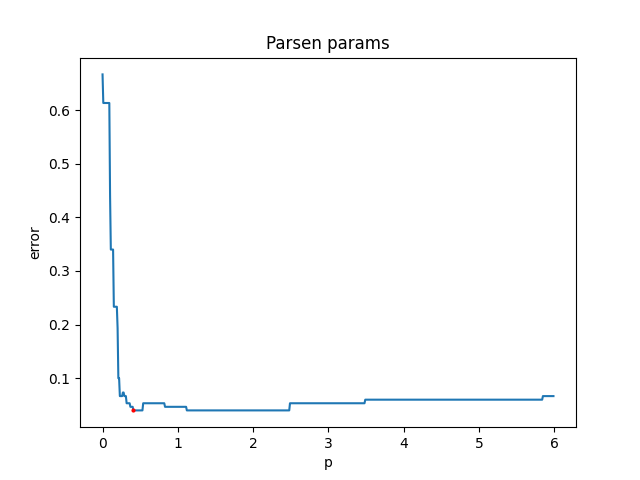

Оптимальная точка равна (p = 0.41, error = 1/25)

Карта классификации

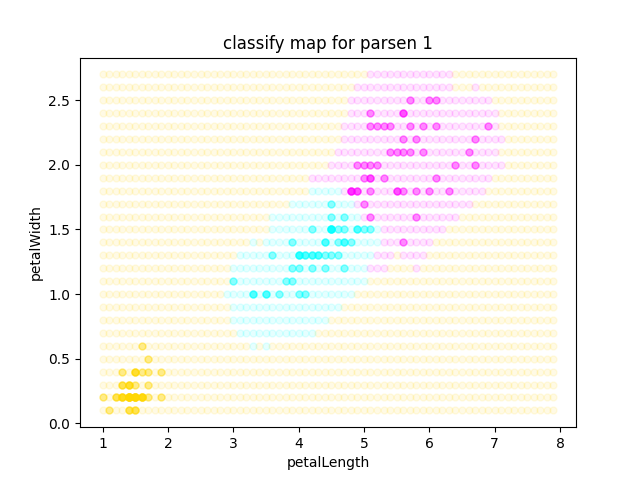

#### Для второго окна

Процесс обучения:

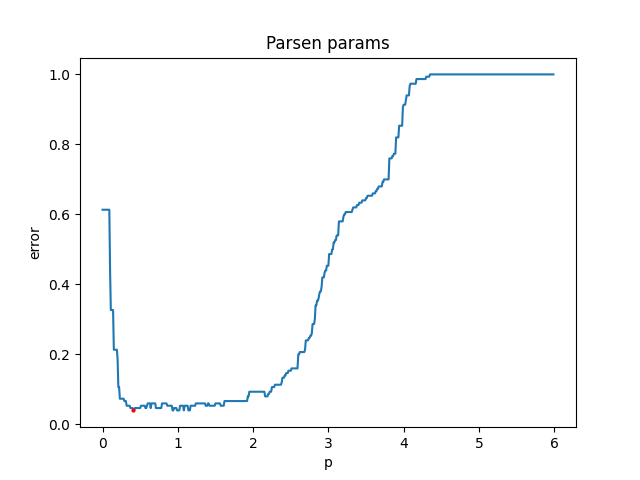

Оптимальная точка равна (p = 0.41, error = 1 / 25).

Карта классификации:

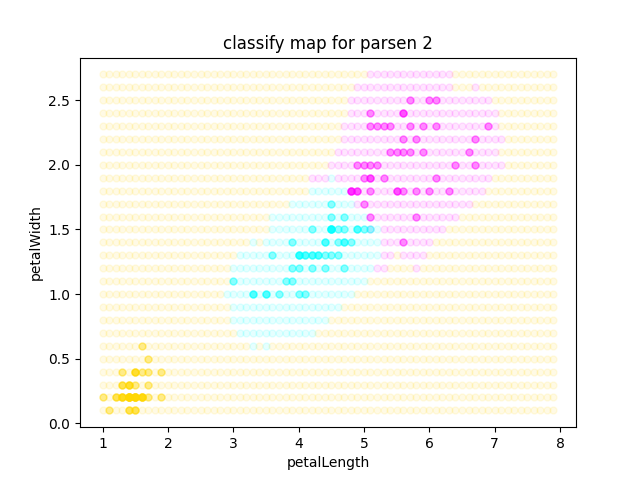

### Вывод

Видно, что первое окно дает результат, равный методы k ближайших соседей с единичным весом, c оптимальными параметрами (k = 6, error = 1/30). Второе окно дает довольно плохой результат, соразмерно с наилучшим, но такой результат вполне подходит для классификации, что видно на карте.